# Basic Usage
The falsification experimentalist identifies experiment conditions under which the loss $\hat{\mathcal{L}}(M,X,Y,\vec{x})$ of the best candidate model is predicted to be the highest. This loss is approximated with a multi-layer perceptron, which is trained to predict the loss of a candidate model, $M$, given experiment conditions $X$  and dependent measures $Y$ that have already been probed.

We begin with importing the relevant packages.

In [1]:
# Uncomment the following line when running on Google Colab
# !pip install "autora[experimentalist-falsification]"

In [2]:
import numpy as np
from sklearn.linear_model import LinearRegression
from autora.variable import DV, IV, ValueType, VariableCollection
from autora.experimentalist.falsification import falsification_sample, falsification_score_sample, falsification_pool

In order to reproduce our results, we also import torch and set the seed.

In [3]:
import torch
torch.manual_seed(180)
np.random.seed(180)

## Example 1: Sampling From A Sine Function

In this example, we will consider a dataset resembling the sine function. We will then fit a linear model to the data and use the falsification sampler to identify experiment conditions under which the model is predicted to perform the worst.

First, we define the experiment conditions $X$ and the observations $Y$. We consider a domain of $X \in [0, 2\pi]$, and sample 100 data points from this domain.

In [4]:
X = np.linspace(0, 2 * np.pi, 100)
Y = np.sin(X)

Next, we need to define metadata object, so the falsification sampler knows what data it is supposed to generate. We can do this by defining the independent variable $x$, which underlies experimental conditions $X$, and the dependent variable $y$, which underlies the observations $Y$. We specify that $x$ is a continuous variable with a range of $[0, 2\pi]$, and $y$ is a real-valued variable.

In [5]:
# Specify independent variable
iv = IV(
    name="x",
    value_range=(0, 2 * np.pi),
)

# specify dependent variable
dv = DV(
    name="y",
    type=ValueType.REAL,
)

# Variable collection with ivs and dvs
metadata = VariableCollection(
    independent_variables=[iv],
    dependent_variables=[dv],
)

Next, we can specify the model that we would like to fit to the data. In this case, we will use a linear model.

In [6]:
model = LinearRegression()
model.fit(X.reshape(-1, 1), Y)

LinearRegression()

Finally, we can generate novel experimental conditions $X'$ from the falsification sampler. We will select 5 novel experimental conditions from a candidate set of 14 experiment conditions.

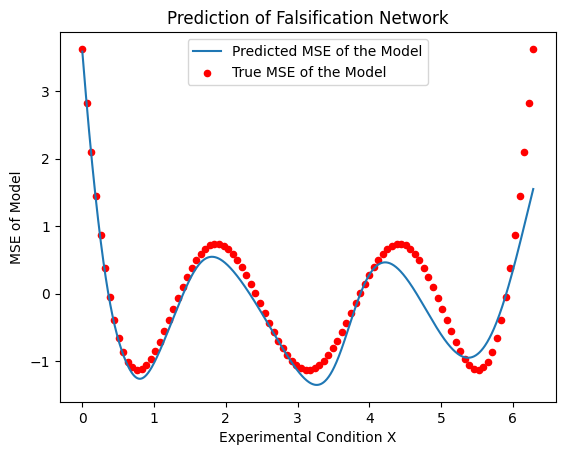

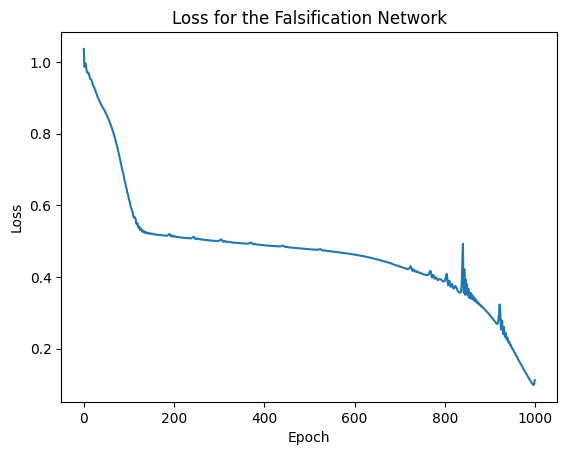

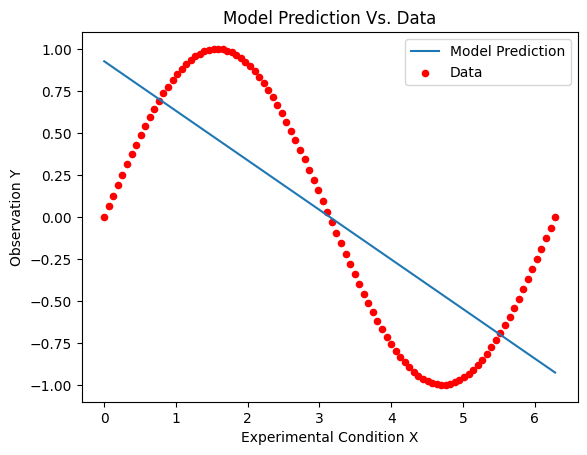

In [7]:
X_prime = np.linspace(0, 6.5, 14)

new_conditions = falsification_sample(
        conditions=X_prime,
        model=model,
        reference_conditions=X,
        reference_observations=Y,
        metadata=metadata,
        num_samples=5,
        plot=True,
    )

Before we examine the novel conditions, let's have a look at the three plots generated by the falsification sampler, going from last to first.

- **Model Prediction vs. Data**. The model trained on the data is shown in red, and the model prediction is shown in blue. The model prediction is a straight line, which is a poor fit to the data. This is expected, since the data is generated from a sine function, which is not linear. <br> <br>

- **Loss of the Falsification Network**. The plot shows the learning curve for the falsification network that is trained to predict the error of the (linear) model as a function of experimental conditions. The error (loss) of this network decreases as a function of the number of training epochs. <br> <br>

- **Prediction of Falsification Experimentalist**. The plot shows the predicted loss of the model as a function of the experimental condition. The model is predicted to perform the worst at the extremes of the domain, which is expected since the model is a poor fit to the data. The red dots show the true loss of the model at the corresponding experimental condition. The predicted loss is a good approximation of the true loss.

The falsification sampler will identify novel experimental conditions that maximize the predicted loss (shown as a blue line in the plot "Prediction of Falsification Experimentalist").

Before examining the selected new conditions, we need to convert them to a numpy array.

In [8]:
new_conditions = np.array(list(new_conditions))
print(new_conditions)

[[0. ]
 [6.5]
 [2. ]
 [6. ]
 [4. ]]


Note that the new conditions are all at the limits of the domain $\{0, 2\pi\}$, as well as around the peaks of the sinusoid, which is expected since the model is a poor fit to the data at those points. We can also plot the new conditions on top of the data.

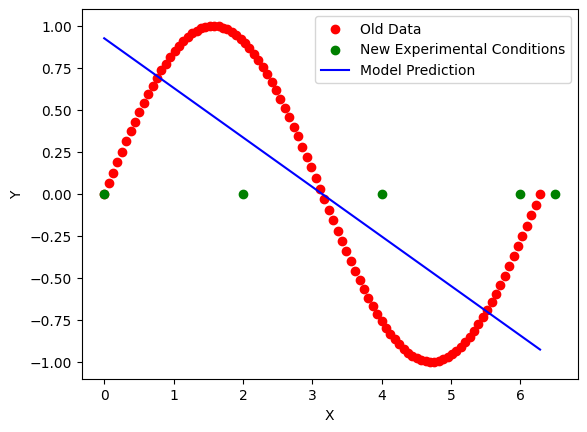

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(X, Y, c="r", label="Old Data")
ax.scatter(new_conditions, np.zeros_like(new_conditions), c="g", label="New Experimental Conditions")
ax.plot(X, model.predict(X.reshape(-1, 1)), c="b", label="Model Prediction")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.legend()

We can also obtain "falsification" scores for the sampled experiment conditions using ``falsification_score_sample''. The scores are z-scored with respect to all conditions from the candidate set. In the following example, we sample 5 conditions and return their falsification scores.

In [10]:
new_conditions = falsification_score_sample(
        conditions=X_prime,
        model=model,
        reference_conditions=X,
        reference_observations=Y,
        metadata=metadata,
        num_samples=5,
    )

print(new_conditions)

     0     score
0  6.5  2.591251
1  0.0  1.901895
2  6.0  0.177879
3  4.5  0.138473
4  2.0  0.115924


Finally, in addition to identifying samples from a candidate set of conditions, we can also generate conditions based on the value ranges of the independent variables as described in the ``metadata`` object. In the following example, we will generate 5 new conditions from the value range of the independent variable $x$. Note that the output of ``falsification_pool`` is an iterator, so we need to convert it to a numpy array.

In [11]:
new_conditions = falsification_pool(
        model=model,
        reference_conditions=X,
        reference_observations=Y,
        metadata=metadata,
        num_samples=5,
        plot=False,
    )

new_conditions = np.array(list(new_conditions))
print(new_conditions)

[[6.28318531]
 [0.        ]
 [6.28318531]
 [0.        ]
 [0.        ]]


## Example 2: Sampling From A Gaussian Mixture Model

In this example, we will consider a dataset sampled from a Gaussian mixture model. We will fit a Gaussian mixture model to the data and use the falsification sampler to identify experiment conditions under which the model is predicted to perform the worst.

First, we define the experimental conditions $X$ and the observations $Y$, and sample 100 data points. The dependent variable is a categorical variable with 2 categories.

In [12]:
from sklearn.datasets import make_blobs
X, Y = make_blobs(n_samples=100, n_features=1, centers=2, random_state=0)

Next, we need to define metadata object, so the falsification sampler knows what data it is supposed to generate. We can do this by defining the independent variable $x$ underlying the experimental conditions $X$ and the dependent variable $y$ underlying the observations $Y$ as "VariableCollection" objects. We specify that $X$ is a continuous variable with a range of $[-1, 6]$, and $Y$ is a categorical variable.

In [13]:
# Specify independent variable
iv = IV(
    name="X",
    value_range=(-1, 6),
)

# specify dependent variable
dv = DV(
    name="Y",
    type=ValueType.CLASS,
)

# Variable collection with ivs and dvs
metadata = VariableCollection(
    independent_variables=[iv],
    dependent_variables=[dv],
)

Next, we can specify the model that we would like to fit to the data. In this case, we will use a Gaussian mixture model with 2 components.

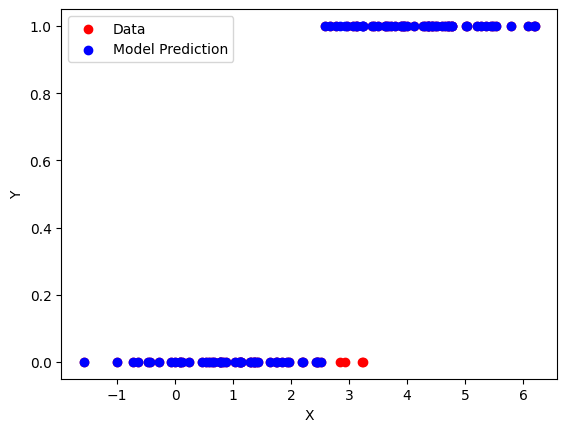

In [14]:
from sklearn.mixture import GaussianMixture
model = GaussianMixture(n_components=2, random_state=2)
model.fit(X, Y)

# plot model fit against data
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(X, Y, c="r", label="Data")
ax.scatter(X, model.predict(X), c="b", label="Model Prediction")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.legend()

In this case, the model appears to predict most of the data points quite well but fails to predict data points around $x=3$. Let's see if the falsification sampler can identify this region of the domain. We will select samples from a candidate set of 71 experiment conditions.

In [15]:
X_prime = np.linspace(-1, 6, 71)

and call the falsification sampler.

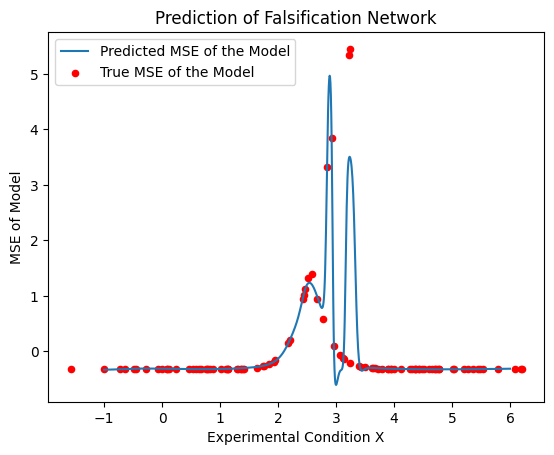

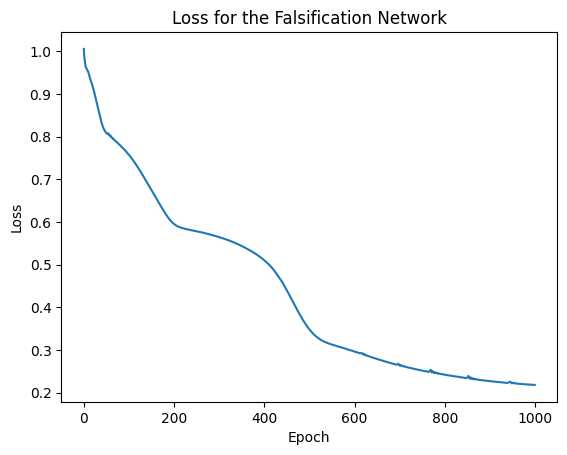

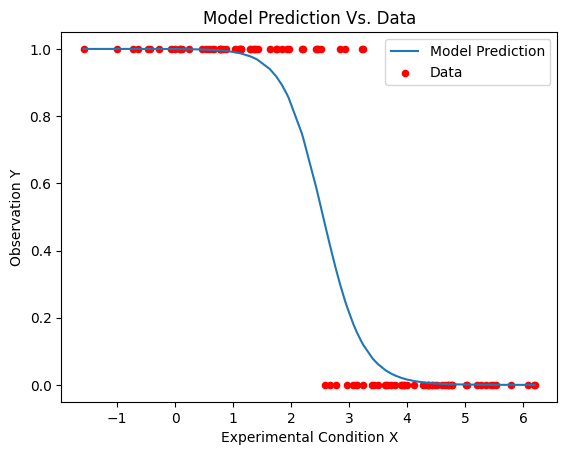

In [16]:
new_conditions = falsification_sample(
        conditions=X_prime,
        model=model,
        reference_conditions=X,
        reference_observations=Y,
        metadata=metadata,
        num_samples=10,
        plot=True,
    )

Alternatively, we could have generated 10 new conditions from the value range of the independent variable $x$ using the falsification pooler.

In [17]:
new_conditions = falsification_pool(
        model=model,
        reference_conditions=X,
        reference_observations=Y,
        metadata=metadata,
        num_samples=10,
        plot=False,
    )

As shown in the "Prediction of Falsification Network" plot, the model is predicted to perform the worst around $x=3$. Let's have a look at the selected new conditions.

In [18]:
new_conditions = np.array(list(new_conditions))
print(new_conditions)

[[3.22912502]
 [5.48685837]
 [3.22912502]
 [2.89068627]
 [3.22912431]
 [3.22912431]
 [2.89068627]
 [2.89068627]
 [3.22912502]
 [3.22912431]]


Indeed, the new conditions mostly located around $x=3$, reflecting a poor fit of the model for those conditions. Finally, we can plot the new conditions on top of the data.

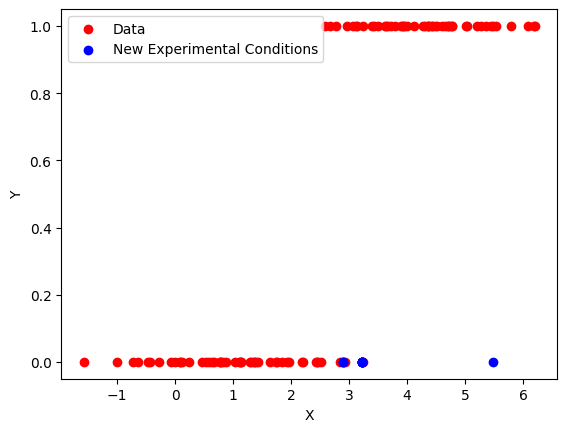

In [19]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(X, Y, c="r", label="Data")
ax.scatter(new_conditions, np.zeros_like(new_conditions), c="b", label="New Experimental Conditions")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.legend()